# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

/bin/sh: 1: unzip: not found


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

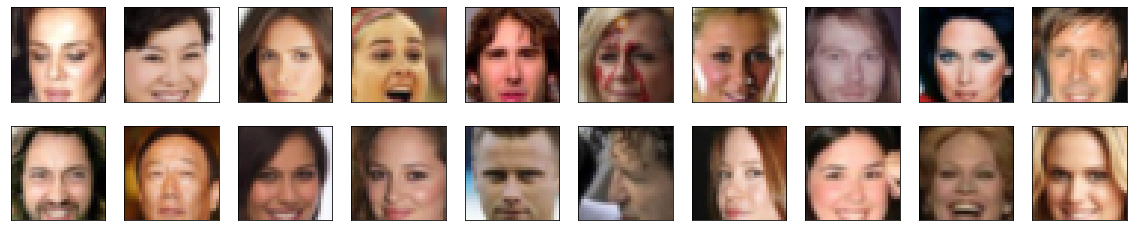

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * 2.0 - 1.0

    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8902)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv_1 = convolution_block(3, conv_dim, batch_norm=False)
        self.conv_2 = convolution_block(conv_dim, conv_dim * 2)
        self.conv_3 = convolution_block(conv_dim * 2, conv_dim * 4)
        self.conv_4 = convolution_block(conv_dim * 4, 1, stride=1, padding=0, batch_norm=False, activation=None)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        
        return x.view(-1, 1)

def convolution_block(in_channels, out_channels, stride=2, padding=1,
                      batch_norm=True, activation=nn.LeakyReLU(0.2, inplace=True)):
    layers = list()
    layers.append(nn.Conv2d(
        in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    if activation is not None:
        layers.append(activation)
    return nn.Sequential(*layers)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.z_size = z_size
        self.deconv_1 = deconvolution_block(z_size, conv_dim * 4, stride=1, padding=0)
        self.deconv_2 = deconvolution_block(conv_dim * 4, conv_dim * 2)
        self.deconv_3 = deconvolution_block(conv_dim * 2, conv_dim)
        self.deconv_4 = deconvolution_block(conv_dim, 3, batch_norm=False, activation=nn.Tanh())

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = x.view(-1, self.z_size, 1, 1)
        x = self.deconv_1(x)
        x = self.deconv_2(x)
        x = self.deconv_3(x)
        x = self.deconv_4(x)
        
        return x

def deconvolution_block(in_channels, out_channels, stride=2, padding=1, batch_norm=True, activation=nn.ReLU(inplace=True)):
    layers = list()
    layers.append(nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(activation)
    return nn.Sequential(*layers)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean=0.0, std=0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(mean=1.0, std=0.02)
        m.bias.data.fill_(0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (deconv_1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    target = torch.ones_like(D_out)
    loss = F.binary_cross_entropy_with_logits(D_out, target)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    target = torch.zeros_like(D_out)
    loss = F.binary_cross_entropy_with_logits(D_out, target)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

learning_rate = 0.0002
beta1 = 0.5

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [ ]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images

            real_output = D(real_images)
            d_real_loss = real_loss(real_output)

            z = torch.empty(batch_size, z_size).uniform_(-1, 1)
            if train_on_gpu:
                z = z.cuda()
            fake_image = G(z)
            fake_output = D(fake_image)
            d_fake_loss = fake_loss(fake_output)

            d_loss = d_real_loss + d_fake_loss
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            z = torch.empty(batch_size, z_size).uniform_(-1, 1)
            if train_on_gpu:
                z = z.cuda()
            fake_image = G(z)
            fake_output = D(fake_image)
            g_loss = real_loss(fake_output)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 500


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  500] | d_loss: 2.0263 | g_loss: 1.5382
Epoch [    1/  500] | d_loss: 0.0814 | g_loss: 5.6428
Epoch [    1/  500] | d_loss: 0.2862 | g_loss: 5.7480
Epoch [    1/  500] | d_loss: 0.1646 | g_loss: 4.9560
Epoch [    1/  500] | d_loss: 0.6440 | g_loss: 6.9240
Epoch [    1/  500] | d_loss: 0.4369 | g_loss: 3.1047
Epoch [    1/  500] | d_loss: 0.5139 | g_loss: 4.6670
Epoch [    1/  500] | d_loss: 0.5290 | g_loss: 4.3975
Epoch [    1/  500] | d_loss: 0.6427 | g_loss: 3.7544
Epoch [    1/  500] | d_loss: 0.9853 | g_loss: 4.5472
Epoch [    1/  500] | d_loss: 1.0589 | g_loss: 4.6708
Epoch [    1/  500] | d_loss: 0.4908 | g_loss: 3.7378
Epoch [    1/  500] | d_loss: 0.5120 | g_loss: 2.7099
Epoch [    1/  500] | d_loss: 0.6060 | g_loss: 2.9707
Epoch [    1/  500] | d_loss: 0.7068 | g_loss: 2.8417
Epoch [    2/  500] | d_loss: 0.8178 | g_loss: 1.1522
Epoch [    2/  500] | d_loss: 0.7089 | g_loss: 2.0113
Epoch [    2/  500] | d_loss: 0.8920 | g_loss: 3.3685
Epoch [    2/  500] | d_loss

Epoch [   11/  500] | d_loss: 0.5976 | g_loss: 2.1836
Epoch [   11/  500] | d_loss: 0.7243 | g_loss: 2.0369
Epoch [   11/  500] | d_loss: 0.6931 | g_loss: 2.2620
Epoch [   11/  500] | d_loss: 0.9703 | g_loss: 0.7741
Epoch [   11/  500] | d_loss: 0.7703 | g_loss: 1.3630
Epoch [   11/  500] | d_loss: 0.5478 | g_loss: 2.4533
Epoch [   11/  500] | d_loss: 0.7081 | g_loss: 2.4354
Epoch [   11/  500] | d_loss: 1.2064 | g_loss: 3.0868
Epoch [   11/  500] | d_loss: 1.0210 | g_loss: 1.1986
Epoch [   11/  500] | d_loss: 0.6090 | g_loss: 1.8827
Epoch [   11/  500] | d_loss: 0.8944 | g_loss: 2.4162
Epoch [   11/  500] | d_loss: 0.6374 | g_loss: 1.8829
Epoch [   11/  500] | d_loss: 0.6562 | g_loss: 1.2803
Epoch [   12/  500] | d_loss: 0.8476 | g_loss: 1.1432
Epoch [   12/  500] | d_loss: 0.6953 | g_loss: 1.7320
Epoch [   12/  500] | d_loss: 0.5797 | g_loss: 1.7135
Epoch [   12/  500] | d_loss: 0.5974 | g_loss: 1.8725
Epoch [   12/  500] | d_loss: 0.8372 | g_loss: 1.4801
Epoch [   12/  500] | d_loss

Epoch [   21/  500] | d_loss: 0.4355 | g_loss: 1.6682
Epoch [   21/  500] | d_loss: 0.5301 | g_loss: 1.8515
Epoch [   21/  500] | d_loss: 0.6982 | g_loss: 2.7732
Epoch [   21/  500] | d_loss: 0.5715 | g_loss: 1.5998
Epoch [   21/  500] | d_loss: 0.4809 | g_loss: 2.4925
Epoch [   21/  500] | d_loss: 0.6537 | g_loss: 1.1958
Epoch [   21/  500] | d_loss: 0.6530 | g_loss: 2.7599
Epoch [   21/  500] | d_loss: 0.4069 | g_loss: 2.6288
Epoch [   21/  500] | d_loss: 0.4534 | g_loss: 1.7804
Epoch [   21/  500] | d_loss: 0.3978 | g_loss: 2.3607
Epoch [   21/  500] | d_loss: 0.4966 | g_loss: 2.2094
Epoch [   22/  500] | d_loss: 0.4633 | g_loss: 3.0634
Epoch [   22/  500] | d_loss: 0.4558 | g_loss: 2.4925
Epoch [   22/  500] | d_loss: 0.5874 | g_loss: 1.8888
Epoch [   22/  500] | d_loss: 0.5860 | g_loss: 2.3040
Epoch [   22/  500] | d_loss: 0.4712 | g_loss: 2.6809
Epoch [   22/  500] | d_loss: 0.2836 | g_loss: 2.8597
Epoch [   22/  500] | d_loss: 0.5033 | g_loss: 3.0726
Epoch [   22/  500] | d_loss

Epoch [   31/  500] | d_loss: 0.3102 | g_loss: 2.4919
Epoch [   31/  500] | d_loss: 0.6207 | g_loss: 3.9373
Epoch [   31/  500] | d_loss: 0.3576 | g_loss: 3.7630
Epoch [   31/  500] | d_loss: 0.6453 | g_loss: 0.9721
Epoch [   31/  500] | d_loss: 0.2783 | g_loss: 2.5679
Epoch [   31/  500] | d_loss: 0.2906 | g_loss: 2.1696
Epoch [   31/  500] | d_loss: 0.3629 | g_loss: 3.0258
Epoch [   31/  500] | d_loss: 0.2439 | g_loss: 2.6266
Epoch [   31/  500] | d_loss: 0.2565 | g_loss: 3.1666
Epoch [   32/  500] | d_loss: 0.2699 | g_loss: 2.7280
Epoch [   32/  500] | d_loss: 1.2210 | g_loss: 0.5853
Epoch [   32/  500] | d_loss: 1.0402 | g_loss: 0.7651
Epoch [   32/  500] | d_loss: 0.2716 | g_loss: 2.0634
Epoch [   32/  500] | d_loss: 0.3218 | g_loss: 3.1348
Epoch [   32/  500] | d_loss: 0.1407 | g_loss: 3.8393
Epoch [   32/  500] | d_loss: 0.6343 | g_loss: 4.0910
Epoch [   32/  500] | d_loss: 0.3524 | g_loss: 2.1779
Epoch [   32/  500] | d_loss: 0.3046 | g_loss: 2.4370
Epoch [   32/  500] | d_loss

Epoch [   41/  500] | d_loss: 0.4488 | g_loss: 1.4078
Epoch [   41/  500] | d_loss: 0.9370 | g_loss: 5.5155
Epoch [   41/  500] | d_loss: 0.2778 | g_loss: 2.9729
Epoch [   41/  500] | d_loss: 0.2710 | g_loss: 2.4153
Epoch [   41/  500] | d_loss: 0.1978 | g_loss: 2.9468
Epoch [   41/  500] | d_loss: 0.3559 | g_loss: 2.2821
Epoch [   41/  500] | d_loss: 0.1679 | g_loss: 4.1096
Epoch [   42/  500] | d_loss: 0.1908 | g_loss: 3.6465
Epoch [   42/  500] | d_loss: 0.8293 | g_loss: 0.5614
Epoch [   42/  500] | d_loss: 0.3721 | g_loss: 4.4197
Epoch [   42/  500] | d_loss: 0.2044 | g_loss: 3.0643
Epoch [   42/  500] | d_loss: 0.2418 | g_loss: 2.6483
Epoch [   42/  500] | d_loss: 0.2582 | g_loss: 2.5006
Epoch [   42/  500] | d_loss: 0.2303 | g_loss: 3.8291
Epoch [   42/  500] | d_loss: 0.2176 | g_loss: 4.6249
Epoch [   42/  500] | d_loss: 0.3169 | g_loss: 3.7637
Epoch [   42/  500] | d_loss: 0.2808 | g_loss: 2.7377
Epoch [   42/  500] | d_loss: 4.2420 | g_loss: 0.0708
Epoch [   42/  500] | d_loss

Epoch [   51/  500] | d_loss: 3.4404 | g_loss: 0.1717
Epoch [   51/  500] | d_loss: 0.2424 | g_loss: 2.8170
Epoch [   51/  500] | d_loss: 0.1615 | g_loss: 3.0238
Epoch [   51/  500] | d_loss: 0.1610 | g_loss: 3.4493
Epoch [   51/  500] | d_loss: 0.1774 | g_loss: 3.7669
Epoch [   52/  500] | d_loss: 0.1336 | g_loss: 3.8847
Epoch [   52/  500] | d_loss: 0.1653 | g_loss: 4.3546
Epoch [   52/  500] | d_loss: 0.2077 | g_loss: 2.4072
Epoch [   52/  500] | d_loss: 0.2411 | g_loss: 2.8899
Epoch [   52/  500] | d_loss: 0.1294 | g_loss: 4.0066
Epoch [   52/  500] | d_loss: 0.9532 | g_loss: 1.8166
Epoch [   52/  500] | d_loss: 0.1845 | g_loss: 3.3220
Epoch [   52/  500] | d_loss: 0.1252 | g_loss: 3.7185
Epoch [   52/  500] | d_loss: 0.2380 | g_loss: 2.1182
Epoch [   52/  500] | d_loss: 1.4338 | g_loss: 0.6436
Epoch [   52/  500] | d_loss: 0.4202 | g_loss: 3.4285
Epoch [   52/  500] | d_loss: 0.4587 | g_loss: 1.7888
Epoch [   52/  500] | d_loss: 0.4227 | g_loss: 4.2889
Epoch [   52/  500] | d_loss

Epoch [   61/  500] | d_loss: 1.4189 | g_loss: 1.0229
Epoch [   61/  500] | d_loss: 0.3104 | g_loss: 4.1625
Epoch [   61/  500] | d_loss: 0.2033 | g_loss: 3.8258
Epoch [   62/  500] | d_loss: 0.2283 | g_loss: 2.9325
Epoch [   62/  500] | d_loss: 0.1050 | g_loss: 3.4043
Epoch [   62/  500] | d_loss: 0.1406 | g_loss: 3.1574
Epoch [   62/  500] | d_loss: 0.1242 | g_loss: 3.4312
Epoch [   62/  500] | d_loss: 0.1088 | g_loss: 5.0188
Epoch [   62/  500] | d_loss: 0.2256 | g_loss: 2.5132
Epoch [   62/  500] | d_loss: 0.1168 | g_loss: 2.9597
Epoch [   62/  500] | d_loss: 0.1347 | g_loss: 4.9774
Epoch [   62/  500] | d_loss: 0.7337 | g_loss: 2.2624
Epoch [   62/  500] | d_loss: 0.4107 | g_loss: 5.7195
Epoch [   62/  500] | d_loss: 0.2259 | g_loss: 3.1183
Epoch [   62/  500] | d_loss: 0.0927 | g_loss: 4.3056
Epoch [   62/  500] | d_loss: 0.1645 | g_loss: 4.5981
Epoch [   62/  500] | d_loss: 0.3219 | g_loss: 1.3794
Epoch [   62/  500] | d_loss: 0.3057 | g_loss: 2.2129
Epoch [   63/  500] | d_loss

Epoch [   71/  500] | d_loss: 0.2703 | g_loss: 2.9927
Epoch [   72/  500] | d_loss: 0.1496 | g_loss: 3.7798
Epoch [   72/  500] | d_loss: 0.1602 | g_loss: 3.6332
Epoch [   72/  500] | d_loss: 0.0692 | g_loss: 3.7704
Epoch [   72/  500] | d_loss: 0.2649 | g_loss: 6.6439
Epoch [   72/  500] | d_loss: 1.1427 | g_loss: 1.9020
Epoch [   72/  500] | d_loss: 1.3665 | g_loss: 1.1228
Epoch [   72/  500] | d_loss: 0.6570 | g_loss: 1.4281
Epoch [   72/  500] | d_loss: 0.8289 | g_loss: 1.9102
Epoch [   72/  500] | d_loss: 0.2065 | g_loss: 3.2609
Epoch [   72/  500] | d_loss: 0.1239 | g_loss: 3.5384
Epoch [   72/  500] | d_loss: 0.1660 | g_loss: 4.1070
Epoch [   72/  500] | d_loss: 0.0518 | g_loss: 3.8642
Epoch [   72/  500] | d_loss: 0.1421 | g_loss: 4.7340
Epoch [   72/  500] | d_loss: 0.0754 | g_loss: 4.0917
Epoch [   72/  500] | d_loss: 1.6162 | g_loss: 1.6742
Epoch [   73/  500] | d_loss: 1.3775 | g_loss: 1.2243
Epoch [   73/  500] | d_loss: 0.8326 | g_loss: 1.4961
Epoch [   73/  500] | d_loss

Epoch [   82/  500] | d_loss: 0.1042 | g_loss: 4.1949
Epoch [   82/  500] | d_loss: 0.1255 | g_loss: 4.3578
Epoch [   82/  500] | d_loss: 0.0939 | g_loss: 4.4348
Epoch [   82/  500] | d_loss: 0.0541 | g_loss: 4.4230
Epoch [   82/  500] | d_loss: 0.6731 | g_loss: 1.6458
Epoch [   82/  500] | d_loss: 0.1219 | g_loss: 4.2801
Epoch [   82/  500] | d_loss: 0.7427 | g_loss: 1.8000
Epoch [   82/  500] | d_loss: 0.2589 | g_loss: 3.9775
Epoch [   82/  500] | d_loss: 0.1620 | g_loss: 3.4882
Epoch [   82/  500] | d_loss: 0.8258 | g_loss: 3.3648
Epoch [   82/  500] | d_loss: 0.1185 | g_loss: 3.1823
Epoch [   82/  500] | d_loss: 0.0710 | g_loss: 3.6776
Epoch [   82/  500] | d_loss: 0.0621 | g_loss: 5.1407
Epoch [   82/  500] | d_loss: 0.1899 | g_loss: 3.9004
Epoch [   83/  500] | d_loss: 0.0761 | g_loss: 4.6842
Epoch [   83/  500] | d_loss: 0.0725 | g_loss: 4.3744
Epoch [   83/  500] | d_loss: 0.0948 | g_loss: 3.7519
Epoch [   83/  500] | d_loss: 0.0827 | g_loss: 4.5574
Epoch [   83/  500] | d_loss

Epoch [   92/  500] | d_loss: 0.0756 | g_loss: 4.5445
Epoch [   92/  500] | d_loss: 0.1208 | g_loss: 3.8779
Epoch [   92/  500] | d_loss: 0.1199 | g_loss: 4.0495
Epoch [   92/  500] | d_loss: 0.1263 | g_loss: 4.7557
Epoch [   92/  500] | d_loss: 0.0979 | g_loss: 5.5765
Epoch [   92/  500] | d_loss: 1.2714 | g_loss: 0.7002
Epoch [   92/  500] | d_loss: 0.3362 | g_loss: 3.9575
Epoch [   92/  500] | d_loss: 0.1755 | g_loss: 4.5156
Epoch [   92/  500] | d_loss: 0.2120 | g_loss: 3.5389
Epoch [   92/  500] | d_loss: 0.6178 | g_loss: 1.2245
Epoch [   92/  500] | d_loss: 4.0900 | g_loss: 5.1197
Epoch [   92/  500] | d_loss: 0.5424 | g_loss: 2.7677
Epoch [   93/  500] | d_loss: 0.3290 | g_loss: 3.7902
Epoch [   93/  500] | d_loss: 0.1368 | g_loss: 3.6368
Epoch [   93/  500] | d_loss: 0.0969 | g_loss: 2.8486
Epoch [   93/  500] | d_loss: 0.1276 | g_loss: 3.3677
Epoch [   93/  500] | d_loss: 0.1716 | g_loss: 4.6207
Epoch [   93/  500] | d_loss: 0.1127 | g_loss: 3.7645
Epoch [   93/  500] | d_loss

Epoch [  102/  500] | d_loss: 0.7304 | g_loss: 2.7772
Epoch [  102/  500] | d_loss: 0.1406 | g_loss: 4.3244
Epoch [  102/  500] | d_loss: 0.1086 | g_loss: 4.6311
Epoch [  102/  500] | d_loss: 0.0707 | g_loss: 5.4655
Epoch [  102/  500] | d_loss: 0.0713 | g_loss: 4.5456
Epoch [  102/  500] | d_loss: 0.0356 | g_loss: 5.4991
Epoch [  102/  500] | d_loss: 0.0661 | g_loss: 4.5577
Epoch [  102/  500] | d_loss: 0.9946 | g_loss: 1.7867
Epoch [  102/  500] | d_loss: 0.2217 | g_loss: 4.6393
Epoch [  102/  500] | d_loss: 0.0935 | g_loss: 4.4844
Epoch [  103/  500] | d_loss: 0.0932 | g_loss: 4.7235
Epoch [  103/  500] | d_loss: 0.6903 | g_loss: 2.1920
Epoch [  103/  500] | d_loss: 0.1375 | g_loss: 4.7911
Epoch [  103/  500] | d_loss: 0.1396 | g_loss: 5.7984
Epoch [  103/  500] | d_loss: 0.0691 | g_loss: 4.4971
Epoch [  103/  500] | d_loss: 0.0362 | g_loss: 4.3127
Epoch [  103/  500] | d_loss: 0.0595 | g_loss: 4.8097
Epoch [  103/  500] | d_loss: 1.3303 | g_loss: 2.0346
Epoch [  103/  500] | d_loss

Epoch [  112/  500] | d_loss: 0.0798 | g_loss: 4.5938
Epoch [  112/  500] | d_loss: 0.0793 | g_loss: 5.4333
Epoch [  112/  500] | d_loss: 0.1574 | g_loss: 3.8117
Epoch [  112/  500] | d_loss: 0.0981 | g_loss: 4.9660
Epoch [  112/  500] | d_loss: 0.0675 | g_loss: 4.8072
Epoch [  112/  500] | d_loss: 0.0448 | g_loss: 4.9535
Epoch [  112/  500] | d_loss: 0.0451 | g_loss: 4.6641
Epoch [  112/  500] | d_loss: 0.1044 | g_loss: 5.2358
Epoch [  113/  500] | d_loss: 0.0404 | g_loss: 4.9730
Epoch [  113/  500] | d_loss: 0.0181 | g_loss: 5.4799
Epoch [  113/  500] | d_loss: 0.5621 | g_loss: 2.4530
Epoch [  113/  500] | d_loss: 0.2427 | g_loss: 3.6755
Epoch [  113/  500] | d_loss: 0.1230 | g_loss: 4.0833
Epoch [  113/  500] | d_loss: 0.2017 | g_loss: 3.4016
Epoch [  113/  500] | d_loss: 0.0997 | g_loss: 4.2819
Epoch [  113/  500] | d_loss: 0.0642 | g_loss: 4.5256
Epoch [  113/  500] | d_loss: 0.0648 | g_loss: 4.7189
Epoch [  113/  500] | d_loss: 0.0848 | g_loss: 4.7392
Epoch [  113/  500] | d_loss

Epoch [  122/  500] | d_loss: 0.1201 | g_loss: 4.1746
Epoch [  122/  500] | d_loss: 1.4384 | g_loss: 0.3200
Epoch [  122/  500] | d_loss: 0.3775 | g_loss: 3.3032
Epoch [  122/  500] | d_loss: 0.0912 | g_loss: 4.9261
Epoch [  122/  500] | d_loss: 0.0939 | g_loss: 4.3106
Epoch [  122/  500] | d_loss: 0.0750 | g_loss: 5.5442
Epoch [  123/  500] | d_loss: 0.2083 | g_loss: 6.2771
Epoch [  123/  500] | d_loss: 0.0749 | g_loss: 3.8909
Epoch [  123/  500] | d_loss: 0.6891 | g_loss: 1.5206
Epoch [  123/  500] | d_loss: 0.4783 | g_loss: 1.8568
Epoch [  123/  500] | d_loss: 0.1412 | g_loss: 3.6285
Epoch [  123/  500] | d_loss: 0.2185 | g_loss: 3.5555
Epoch [  123/  500] | d_loss: 0.1838 | g_loss: 5.4781
Epoch [  123/  500] | d_loss: 0.1124 | g_loss: 6.3003
Epoch [  123/  500] | d_loss: 0.1828 | g_loss: 3.5709
Epoch [  123/  500] | d_loss: 0.0469 | g_loss: 5.1264
Epoch [  123/  500] | d_loss: 0.0702 | g_loss: 4.8478
Epoch [  123/  500] | d_loss: 1.1134 | g_loss: 2.0217
Epoch [  123/  500] | d_loss

Epoch [  132/  500] | d_loss: 0.0465 | g_loss: 6.2638
Epoch [  132/  500] | d_loss: 0.0578 | g_loss: 5.5140
Epoch [  132/  500] | d_loss: 0.0524 | g_loss: 5.7401
Epoch [  132/  500] | d_loss: 0.1347 | g_loss: 5.0616
Epoch [  133/  500] | d_loss: 0.2274 | g_loss: 5.9060
Epoch [  133/  500] | d_loss: 0.0458 | g_loss: 5.1115
Epoch [  133/  500] | d_loss: 0.9253 | g_loss: 1.6146
Epoch [  133/  500] | d_loss: 0.1548 | g_loss: 3.8417
Epoch [  133/  500] | d_loss: 0.1332 | g_loss: 4.4920
Epoch [  133/  500] | d_loss: 0.0815 | g_loss: 4.5184
Epoch [  133/  500] | d_loss: 0.0606 | g_loss: 5.7623
Epoch [  133/  500] | d_loss: 0.0749 | g_loss: 5.0141
Epoch [  133/  500] | d_loss: 0.0731 | g_loss: 5.3773
Epoch [  133/  500] | d_loss: 0.0428 | g_loss: 4.8000
Epoch [  133/  500] | d_loss: 0.0673 | g_loss: 4.7546
Epoch [  133/  500] | d_loss: 0.1265 | g_loss: 3.1710
Epoch [  133/  500] | d_loss: 0.0503 | g_loss: 5.3905
Epoch [  133/  500] | d_loss: 0.0499 | g_loss: 5.4646
Epoch [  133/  500] | d_loss

Epoch [  142/  500] | d_loss: 0.2197 | g_loss: 5.4308
Epoch [  142/  500] | d_loss: 0.0621 | g_loss: 5.1167
Epoch [  143/  500] | d_loss: 0.0523 | g_loss: 4.9555
Epoch [  143/  500] | d_loss: 0.0310 | g_loss: 5.4995
Epoch [  143/  500] | d_loss: 0.6982 | g_loss: 1.8484
Epoch [  143/  500] | d_loss: 0.1935 | g_loss: 2.7227
Epoch [  143/  500] | d_loss: 0.0720 | g_loss: 6.5108
Epoch [  143/  500] | d_loss: 0.0589 | g_loss: 5.6627
Epoch [  143/  500] | d_loss: 0.0502 | g_loss: 5.6151
Epoch [  143/  500] | d_loss: 0.0670 | g_loss: 4.7436
Epoch [  143/  500] | d_loss: 0.0810 | g_loss: 4.9418
Epoch [  143/  500] | d_loss: 0.0448 | g_loss: 5.1432
Epoch [  143/  500] | d_loss: 0.0329 | g_loss: 5.7164
Epoch [  143/  500] | d_loss: 0.0697 | g_loss: 4.2425
Epoch [  143/  500] | d_loss: 0.2118 | g_loss: 3.0920
Epoch [  143/  500] | d_loss: 0.0496 | g_loss: 5.1750
Epoch [  143/  500] | d_loss: 0.0681 | g_loss: 4.8471
Epoch [  144/  500] | d_loss: 0.0728 | g_loss: 5.3364
Epoch [  144/  500] | d_loss

Epoch [  153/  500] | d_loss: 0.1427 | g_loss: 6.1269
Epoch [  153/  500] | d_loss: 0.0623 | g_loss: 4.7641
Epoch [  153/  500] | d_loss: 0.0793 | g_loss: 5.0377
Epoch [  153/  500] | d_loss: 0.0671 | g_loss: 5.7182
Epoch [  153/  500] | d_loss: 0.0436 | g_loss: 4.7228
Epoch [  153/  500] | d_loss: 0.0375 | g_loss: 6.5126
Epoch [  153/  500] | d_loss: 1.3249 | g_loss: 1.1288
Epoch [  153/  500] | d_loss: 0.5872 | g_loss: 2.1421
Epoch [  153/  500] | d_loss: 0.1321 | g_loss: 4.4872
Epoch [  153/  500] | d_loss: 0.0672 | g_loss: 5.1083
Epoch [  153/  500] | d_loss: 2.3411 | g_loss: 0.2841
Epoch [  153/  500] | d_loss: 0.1576 | g_loss: 4.5559
Epoch [  153/  500] | d_loss: 0.1067 | g_loss: 5.5213
Epoch [  153/  500] | d_loss: 0.0927 | g_loss: 4.1426
Epoch [  153/  500] | d_loss: 0.0472 | g_loss: 5.5831
Epoch [  154/  500] | d_loss: 0.0642 | g_loss: 5.3193
Epoch [  154/  500] | d_loss: 0.0905 | g_loss: 4.3275
Epoch [  154/  500] | d_loss: 0.0880 | g_loss: 5.0978
Epoch [  154/  500] | d_loss

Epoch [  163/  500] | d_loss: 0.1159 | g_loss: 4.1929
Epoch [  163/  500] | d_loss: 0.0997 | g_loss: 5.1302
Epoch [  163/  500] | d_loss: 0.0725 | g_loss: 5.7880
Epoch [  163/  500] | d_loss: 0.0611 | g_loss: 5.0049
Epoch [  163/  500] | d_loss: 0.0535 | g_loss: 5.1570
Epoch [  163/  500] | d_loss: 0.0475 | g_loss: 5.9731
Epoch [  163/  500] | d_loss: 0.4140 | g_loss: 2.4959
Epoch [  163/  500] | d_loss: 0.1290 | g_loss: 4.9686
Epoch [  163/  500] | d_loss: 0.0725 | g_loss: 5.8636
Epoch [  163/  500] | d_loss: 0.1172 | g_loss: 4.7594
Epoch [  163/  500] | d_loss: 0.0721 | g_loss: 5.1053
Epoch [  163/  500] | d_loss: 0.0462 | g_loss: 5.1066
Epoch [  163/  500] | d_loss: 0.0327 | g_loss: 5.5371
Epoch [  164/  500] | d_loss: 0.0282 | g_loss: 5.4281
Epoch [  164/  500] | d_loss: 0.4166 | g_loss: 3.4875
Epoch [  164/  500] | d_loss: 0.1096 | g_loss: 4.7958
Epoch [  164/  500] | d_loss: 0.0844 | g_loss: 4.8874
Epoch [  164/  500] | d_loss: 0.1049 | g_loss: 3.6986
Epoch [  164/  500] | d_loss

Epoch [  173/  500] | d_loss: 0.0571 | g_loss: 5.4911
Epoch [  173/  500] | d_loss: 0.0627 | g_loss: 4.8724
Epoch [  173/  500] | d_loss: 0.0302 | g_loss: 7.6393
Epoch [  173/  500] | d_loss: 0.0379 | g_loss: 5.8845
Epoch [  173/  500] | d_loss: 0.0617 | g_loss: 4.7739
Epoch [  173/  500] | d_loss: 0.0596 | g_loss: 4.2364
Epoch [  173/  500] | d_loss: 0.0929 | g_loss: 3.8133
Epoch [  173/  500] | d_loss: 0.0215 | g_loss: 6.4846
Epoch [  173/  500] | d_loss: 0.0160 | g_loss: 5.6776
Epoch [  173/  500] | d_loss: 1.4290 | g_loss: 1.7247
Epoch [  173/  500] | d_loss: 0.4069 | g_loss: 1.9430
Epoch [  174/  500] | d_loss: 2.0791 | g_loss: 4.1855
Epoch [  174/  500] | d_loss: 1.5935 | g_loss: 4.3068
Epoch [  174/  500] | d_loss: 0.1556 | g_loss: 3.5640
Epoch [  174/  500] | d_loss: 1.3050 | g_loss: 0.5140
Epoch [  174/  500] | d_loss: 0.1345 | g_loss: 5.3033
Epoch [  174/  500] | d_loss: 0.0666 | g_loss: 5.4561
Epoch [  174/  500] | d_loss: 0.2268 | g_loss: 3.3602
Epoch [  174/  500] | d_loss

Epoch [  183/  500] | d_loss: 0.0459 | g_loss: 5.0213
Epoch [  183/  500] | d_loss: 0.0970 | g_loss: 4.0739
Epoch [  183/  500] | d_loss: 0.0605 | g_loss: 4.5767
Epoch [  183/  500] | d_loss: 0.0222 | g_loss: 7.1277
Epoch [  183/  500] | d_loss: 0.0639 | g_loss: 6.4486
Epoch [  183/  500] | d_loss: 0.0889 | g_loss: 5.2725
Epoch [  183/  500] | d_loss: 0.0653 | g_loss: 6.2889
Epoch [  183/  500] | d_loss: 0.0253 | g_loss: 4.9454
Epoch [  183/  500] | d_loss: 0.3071 | g_loss: 6.8463
Epoch [  184/  500] | d_loss: 0.1567 | g_loss: 7.4045
Epoch [  184/  500] | d_loss: 0.0909 | g_loss: 5.4092
Epoch [  184/  500] | d_loss: 0.0849 | g_loss: 5.9510
Epoch [  184/  500] | d_loss: 1.8285 | g_loss: 0.5628
Epoch [  184/  500] | d_loss: 1.0978 | g_loss: 0.9128
Epoch [  184/  500] | d_loss: 0.4492 | g_loss: 5.2674
Epoch [  184/  500] | d_loss: 0.2931 | g_loss: 3.4290
Epoch [  184/  500] | d_loss: 0.4221 | g_loss: 3.3045
Epoch [  184/  500] | d_loss: 3.1641 | g_loss: 7.1463
Epoch [  184/  500] | d_loss

Epoch [  193/  500] | d_loss: 0.0850 | g_loss: 4.9574
Epoch [  193/  500] | d_loss: 0.2668 | g_loss: 5.2247
Epoch [  193/  500] | d_loss: 0.0301 | g_loss: 4.7734
Epoch [  193/  500] | d_loss: 0.0498 | g_loss: 4.9001
Epoch [  193/  500] | d_loss: 0.1139 | g_loss: 4.3308
Epoch [  193/  500] | d_loss: 0.0796 | g_loss: 5.0295
Epoch [  193/  500] | d_loss: 0.0687 | g_loss: 5.2799
Epoch [  194/  500] | d_loss: 0.0320 | g_loss: 5.8692
Epoch [  194/  500] | d_loss: 0.0599 | g_loss: 5.4988
Epoch [  194/  500] | d_loss: 0.5784 | g_loss: 3.4729
Epoch [  194/  500] | d_loss: 0.0521 | g_loss: 4.3626
Epoch [  194/  500] | d_loss: 0.0277 | g_loss: 5.6744
Epoch [  194/  500] | d_loss: 0.0518 | g_loss: 5.7203
Epoch [  194/  500] | d_loss: 0.0377 | g_loss: 6.3665
Epoch [  194/  500] | d_loss: 0.0210 | g_loss: 4.6641
Epoch [  194/  500] | d_loss: 0.0717 | g_loss: 5.1928
Epoch [  194/  500] | d_loss: 0.0713 | g_loss: 4.9322
Epoch [  194/  500] | d_loss: 0.0241 | g_loss: 5.7308
Epoch [  194/  500] | d_loss

Epoch [  203/  500] | d_loss: 0.0627 | g_loss: 4.7030
Epoch [  203/  500] | d_loss: 0.0750 | g_loss: 4.5943
Epoch [  203/  500] | d_loss: 0.0366 | g_loss: 6.3182
Epoch [  203/  500] | d_loss: 0.0978 | g_loss: 3.8711
Epoch [  203/  500] | d_loss: 0.1009 | g_loss: 4.1789
Epoch [  204/  500] | d_loss: 0.0564 | g_loss: 6.3645
Epoch [  204/  500] | d_loss: 0.1413 | g_loss: 4.4421
Epoch [  204/  500] | d_loss: 0.0429 | g_loss: 7.2309
Epoch [  204/  500] | d_loss: 0.0381 | g_loss: 5.2931
Epoch [  204/  500] | d_loss: 0.0565 | g_loss: 4.5431
Epoch [  204/  500] | d_loss: 0.0386 | g_loss: 4.9029
Epoch [  204/  500] | d_loss: 0.0443 | g_loss: 4.9863
Epoch [  204/  500] | d_loss: 0.2492 | g_loss: 4.6087
Epoch [  204/  500] | d_loss: 0.6394 | g_loss: 2.4940
Epoch [  204/  500] | d_loss: 0.1142 | g_loss: 4.8747
Epoch [  204/  500] | d_loss: 0.0891 | g_loss: 4.9694
Epoch [  204/  500] | d_loss: 0.0661 | g_loss: 3.8243
Epoch [  204/  500] | d_loss: 0.0973 | g_loss: 4.1643
Epoch [  204/  500] | d_loss

Epoch [  213/  500] | d_loss: 0.0958 | g_loss: 6.0141
Epoch [  213/  500] | d_loss: 0.0862 | g_loss: 4.4653
Epoch [  213/  500] | d_loss: 0.0422 | g_loss: 6.9540
Epoch [  214/  500] | d_loss: 0.1138 | g_loss: 4.4022
Epoch [  214/  500] | d_loss: 0.0398 | g_loss: 4.8366
Epoch [  214/  500] | d_loss: 0.5681 | g_loss: 1.6495
Epoch [  214/  500] | d_loss: 0.0434 | g_loss: 4.7407
Epoch [  214/  500] | d_loss: 0.0645 | g_loss: 4.3687
Epoch [  214/  500] | d_loss: 0.1433 | g_loss: 4.1460
Epoch [  214/  500] | d_loss: 0.0344 | g_loss: 4.8442
Epoch [  214/  500] | d_loss: 0.1028 | g_loss: 5.4355
Epoch [  214/  500] | d_loss: 0.2233 | g_loss: 6.4412
Epoch [  214/  500] | d_loss: 0.0216 | g_loss: 5.5257
Epoch [  214/  500] | d_loss: 0.0351 | g_loss: 5.8992
Epoch [  214/  500] | d_loss: 0.0496 | g_loss: 4.8481
Epoch [  214/  500] | d_loss: 0.0466 | g_loss: 3.8449
Epoch [  214/  500] | d_loss: 0.0568 | g_loss: 4.5731
Epoch [  214/  500] | d_loss: 0.0547 | g_loss: 5.9293
Epoch [  215/  500] | d_loss

Epoch [  223/  500] | d_loss: 0.0229 | g_loss: 6.7656
Epoch [  224/  500] | d_loss: 0.0338 | g_loss: 6.2813
Epoch [  224/  500] | d_loss: 0.0806 | g_loss: 6.1984
Epoch [  224/  500] | d_loss: 0.5595 | g_loss: 2.8185
Epoch [  224/  500] | d_loss: 0.0647 | g_loss: 6.1241
Epoch [  224/  500] | d_loss: 0.0257 | g_loss: 6.4549
Epoch [  224/  500] | d_loss: 0.1234 | g_loss: 4.1717
Epoch [  224/  500] | d_loss: 0.0724 | g_loss: 5.0085
Epoch [  224/  500] | d_loss: 0.2467 | g_loss: 7.9791
Epoch [  224/  500] | d_loss: 0.1212 | g_loss: 4.7006
Epoch [  224/  500] | d_loss: 0.0367 | g_loss: 6.5657
Epoch [  224/  500] | d_loss: 0.0229 | g_loss: 5.7189
Epoch [  224/  500] | d_loss: 0.0910 | g_loss: 5.4034
Epoch [  224/  500] | d_loss: 0.0456 | g_loss: 5.8435
Epoch [  224/  500] | d_loss: 0.1307 | g_loss: 4.6120
Epoch [  224/  500] | d_loss: 0.0480 | g_loss: 5.8649
Epoch [  225/  500] | d_loss: 0.0394 | g_loss: 5.9371
Epoch [  225/  500] | d_loss: 0.0274 | g_loss: 5.2239
Epoch [  225/  500] | d_loss

Epoch [  234/  500] | d_loss: 0.0618 | g_loss: 6.1593
Epoch [  234/  500] | d_loss: 0.0370 | g_loss: 6.1774
Epoch [  234/  500] | d_loss: 0.0330 | g_loss: 7.3040
Epoch [  234/  500] | d_loss: 0.0462 | g_loss: 5.1711
Epoch [  234/  500] | d_loss: 0.0285 | g_loss: 6.7631
Epoch [  234/  500] | d_loss: 0.0428 | g_loss: 5.1609
Epoch [  234/  500] | d_loss: 0.0309 | g_loss: 5.5139
Epoch [  234/  500] | d_loss: 0.0488 | g_loss: 4.3602
Epoch [  234/  500] | d_loss: 0.0330 | g_loss: 6.6054
Epoch [  234/  500] | d_loss: 0.0368 | g_loss: 5.5558
Epoch [  234/  500] | d_loss: 0.0351 | g_loss: 7.1744
Epoch [  234/  500] | d_loss: 0.0326 | g_loss: 5.5557
Epoch [  234/  500] | d_loss: 0.0692 | g_loss: 3.7516
Epoch [  234/  500] | d_loss: 0.0638 | g_loss: 4.9627
Epoch [  235/  500] | d_loss: 0.0132 | g_loss: 5.7470
Epoch [  235/  500] | d_loss: 0.0567 | g_loss: 5.2045
Epoch [  235/  500] | d_loss: 0.0349 | g_loss: 6.5747
Epoch [  235/  500] | d_loss: 0.0625 | g_loss: 5.6086
Epoch [  235/  500] | d_loss

Epoch [  244/  500] | d_loss: 0.0961 | g_loss: 6.6672
Epoch [  244/  500] | d_loss: 0.1222 | g_loss: 5.8562
Epoch [  244/  500] | d_loss: 0.0395 | g_loss: 6.1100
Epoch [  244/  500] | d_loss: 0.0779 | g_loss: 5.3296
Epoch [  244/  500] | d_loss: 0.0393 | g_loss: 5.3851
Epoch [  244/  500] | d_loss: 0.0552 | g_loss: 4.7926
Epoch [  244/  500] | d_loss: 0.0358 | g_loss: 6.1030
Epoch [  244/  500] | d_loss: 0.0392 | g_loss: 4.5388
Epoch [  244/  500] | d_loss: 0.0412 | g_loss: 5.3309
Epoch [  244/  500] | d_loss: 0.0365 | g_loss: 6.5558
Epoch [  244/  500] | d_loss: 0.0623 | g_loss: 5.2740
Epoch [  244/  500] | d_loss: 0.0328 | g_loss: 6.3852
Epoch [  245/  500] | d_loss: 0.0590 | g_loss: 6.4653
Epoch [  245/  500] | d_loss: 0.0406 | g_loss: 6.8444
Epoch [  245/  500] | d_loss: 0.0185 | g_loss: 5.6988
Epoch [  245/  500] | d_loss: 0.0384 | g_loss: 6.4369
Epoch [  245/  500] | d_loss: 0.1022 | g_loss: 6.3782
Epoch [  245/  500] | d_loss: 1.1415 | g_loss: 1.1412
Epoch [  245/  500] | d_loss

Epoch [  254/  500] | d_loss: 0.0167 | g_loss: 6.8501
Epoch [  254/  500] | d_loss: 0.0414 | g_loss: 7.1310
Epoch [  254/  500] | d_loss: 0.0412 | g_loss: 5.5934
Epoch [  254/  500] | d_loss: 0.0627 | g_loss: 5.4163
Epoch [  254/  500] | d_loss: 0.0343 | g_loss: 6.8406
Epoch [  254/  500] | d_loss: 0.1024 | g_loss: 7.4204
Epoch [  254/  500] | d_loss: 0.0348 | g_loss: 6.1185
Epoch [  254/  500] | d_loss: 6.7207 | g_loss: 0.5298
Epoch [  254/  500] | d_loss: 0.4943 | g_loss: 4.9288
Epoch [  254/  500] | d_loss: 0.0965 | g_loss: 6.4123
Epoch [  255/  500] | d_loss: 0.0932 | g_loss: 5.3517
Epoch [  255/  500] | d_loss: 0.8061 | g_loss: 2.1435
Epoch [  255/  500] | d_loss: 0.1231 | g_loss: 3.8564
Epoch [  255/  500] | d_loss: 0.0817 | g_loss: 5.4450
Epoch [  255/  500] | d_loss: 0.0539 | g_loss: 6.7042
Epoch [  255/  500] | d_loss: 0.0495 | g_loss: 5.4205
Epoch [  255/  500] | d_loss: 0.0440 | g_loss: 5.3818
Epoch [  255/  500] | d_loss: 0.0331 | g_loss: 6.1455
Epoch [  255/  500] | d_loss

Epoch [  264/  500] | d_loss: 0.0303 | g_loss: 6.0747
Epoch [  264/  500] | d_loss: 0.0536 | g_loss: 6.0010
Epoch [  264/  500] | d_loss: 0.0470 | g_loss: 5.8044
Epoch [  264/  500] | d_loss: 0.0614 | g_loss: 6.6587
Epoch [  264/  500] | d_loss: 0.0418 | g_loss: 5.9034
Epoch [  264/  500] | d_loss: 0.1572 | g_loss: 3.2641
Epoch [  264/  500] | d_loss: 0.1114 | g_loss: 6.2393
Epoch [  264/  500] | d_loss: 0.0838 | g_loss: 5.8565
Epoch [  265/  500] | d_loss: 0.0708 | g_loss: 5.4160
Epoch [  265/  500] | d_loss: 0.0581 | g_loss: 4.5491
Epoch [  265/  500] | d_loss: 0.0788 | g_loss: 5.2343
Epoch [  265/  500] | d_loss: 0.0805 | g_loss: 7.4670
Epoch [  265/  500] | d_loss: 0.0902 | g_loss: 6.3067
Epoch [  265/  500] | d_loss: 0.0306 | g_loss: 5.5583
Epoch [  265/  500] | d_loss: 0.0608 | g_loss: 5.4171
Epoch [  265/  500] | d_loss: 0.0279 | g_loss: 5.7678
Epoch [  265/  500] | d_loss: 0.0552 | g_loss: 5.2869
Epoch [  265/  500] | d_loss: 0.1696 | g_loss: 4.1463
Epoch [  265/  500] | d_loss

Epoch [  274/  500] | d_loss: 0.0362 | g_loss: 6.8662
Epoch [  274/  500] | d_loss: 0.0561 | g_loss: 5.8956
Epoch [  274/  500] | d_loss: 0.0345 | g_loss: 5.6941
Epoch [  274/  500] | d_loss: 0.0603 | g_loss: 6.7647
Epoch [  274/  500] | d_loss: 0.0928 | g_loss: 5.6557
Epoch [  274/  500] | d_loss: 1.4217 | g_loss: 1.2114
Epoch [  275/  500] | d_loss: 0.4424 | g_loss: 2.9498
Epoch [  275/  500] | d_loss: 0.0589 | g_loss: 4.7163
Epoch [  275/  500] | d_loss: 0.0556 | g_loss: 7.6441
Epoch [  275/  500] | d_loss: 0.0499 | g_loss: 6.4941
Epoch [  275/  500] | d_loss: 0.0316 | g_loss: 5.9232
Epoch [  275/  500] | d_loss: 0.0560 | g_loss: 7.2407
Epoch [  275/  500] | d_loss: 0.0426 | g_loss: 5.5182
Epoch [  275/  500] | d_loss: 0.0307 | g_loss: 6.4281
Epoch [  275/  500] | d_loss: 0.0429 | g_loss: 5.8984
Epoch [  275/  500] | d_loss: 0.0208 | g_loss: 7.1955
Epoch [  275/  500] | d_loss: 0.0158 | g_loss: 6.3728
Epoch [  275/  500] | d_loss: 0.0738 | g_loss: 5.2143
Epoch [  275/  500] | d_loss

Epoch [  284/  500] | d_loss: 0.1518 | g_loss: 3.0173
Epoch [  284/  500] | d_loss: 0.0413 | g_loss: 6.8685
Epoch [  284/  500] | d_loss: 0.0295 | g_loss: 6.1780
Epoch [  284/  500] | d_loss: 0.0313 | g_loss: 6.2331
Epoch [  285/  500] | d_loss: 0.0504 | g_loss: 5.6624
Epoch [  285/  500] | d_loss: 0.0810 | g_loss: 6.4167
Epoch [  285/  500] | d_loss: 0.0289 | g_loss: 5.6338
Epoch [  285/  500] | d_loss: 0.0276 | g_loss: 5.9568
Epoch [  285/  500] | d_loss: 0.0409 | g_loss: 5.2902
Epoch [  285/  500] | d_loss: 0.0607 | g_loss: 5.5521
Epoch [  285/  500] | d_loss: 0.0257 | g_loss: 5.4447
Epoch [  285/  500] | d_loss: 0.0173 | g_loss: 7.7940
Epoch [  285/  500] | d_loss: 0.0319 | g_loss: 5.4387
Epoch [  285/  500] | d_loss: 0.0268 | g_loss: 4.9514
Epoch [  285/  500] | d_loss: 0.0384 | g_loss: 6.1243
Epoch [  285/  500] | d_loss: 1.6303 | g_loss: 2.2384
Epoch [  285/  500] | d_loss: 0.5624 | g_loss: 0.9713
Epoch [  285/  500] | d_loss: 0.1038 | g_loss: 3.4375
Epoch [  285/  500] | d_loss

Epoch [  294/  500] | d_loss: 0.0175 | g_loss: 5.5345
Epoch [  294/  500] | d_loss: 0.0220 | g_loss: 7.6460
Epoch [  295/  500] | d_loss: 0.1143 | g_loss: 6.3176
Epoch [  295/  500] | d_loss: 0.0310 | g_loss: 5.8099
Epoch [  295/  500] | d_loss: 1.2144 | g_loss: 1.3837
Epoch [  295/  500] | d_loss: 0.1755 | g_loss: 5.7686
Epoch [  295/  500] | d_loss: 0.0319 | g_loss: 8.0673
Epoch [  295/  500] | d_loss: 0.0840 | g_loss: 5.5355
Epoch [  295/  500] | d_loss: 0.0352 | g_loss: 5.8359
Epoch [  295/  500] | d_loss: 0.0853 | g_loss: 5.3940
Epoch [  295/  500] | d_loss: 0.0460 | g_loss: 5.3706
Epoch [  295/  500] | d_loss: 0.0198 | g_loss: 6.2415
Epoch [  295/  500] | d_loss: 0.0348 | g_loss: 5.0226
Epoch [  295/  500] | d_loss: 0.6685 | g_loss: 1.9471
Epoch [  295/  500] | d_loss: 0.0279 | g_loss: 5.9408
Epoch [  295/  500] | d_loss: 0.0357 | g_loss: 6.8476
Epoch [  295/  500] | d_loss: 0.0491 | g_loss: 5.4570
Epoch [  296/  500] | d_loss: 0.2696 | g_loss: 7.2196
Epoch [  296/  500] | d_loss

Epoch [  305/  500] | d_loss: 0.8622 | g_loss: 4.8683
Epoch [  305/  500] | d_loss: 0.3097 | g_loss: 5.2222
Epoch [  305/  500] | d_loss: 0.0783 | g_loss: 4.7486
Epoch [  305/  500] | d_loss: 0.2514 | g_loss: 4.3166
Epoch [  305/  500] | d_loss: 0.0727 | g_loss: 6.0862
Epoch [  305/  500] | d_loss: 0.0731 | g_loss: 5.0733
Epoch [  305/  500] | d_loss: 0.0435 | g_loss: 6.8282
Epoch [  305/  500] | d_loss: 0.0952 | g_loss: 6.4323
Epoch [  305/  500] | d_loss: 0.0702 | g_loss: 5.5625
Epoch [  305/  500] | d_loss: 0.0350 | g_loss: 6.4531
Epoch [  305/  500] | d_loss: 0.0633 | g_loss: 6.1628
Epoch [  305/  500] | d_loss: 0.0308 | g_loss: 5.8487
Epoch [  305/  500] | d_loss: 0.0670 | g_loss: 5.8705
Epoch [  305/  500] | d_loss: 0.0323 | g_loss: 5.3092
Epoch [  305/  500] | d_loss: 0.0211 | g_loss: 7.1516
Epoch [  306/  500] | d_loss: 0.0277 | g_loss: 6.4143
Epoch [  306/  500] | d_loss: 0.0564 | g_loss: 5.5956
Epoch [  306/  500] | d_loss: 0.0432 | g_loss: 6.5308
Epoch [  306/  500] | d_loss

Epoch [  315/  500] | d_loss: 0.0239 | g_loss: 6.2545
Epoch [  315/  500] | d_loss: 0.0497 | g_loss: 6.5832
Epoch [  315/  500] | d_loss: 0.0465 | g_loss: 6.3744
Epoch [  315/  500] | d_loss: 0.0511 | g_loss: 6.9001
Epoch [  315/  500] | d_loss: 0.0393 | g_loss: 6.3906
Epoch [  315/  500] | d_loss: 0.0234 | g_loss: 6.4360
Epoch [  315/  500] | d_loss: 0.6794 | g_loss: 2.6603
Epoch [  315/  500] | d_loss: 0.2141 | g_loss: 8.1641
Epoch [  315/  500] | d_loss: 0.0906 | g_loss: 8.6709
Epoch [  315/  500] | d_loss: 0.0487 | g_loss: 4.9681
Epoch [  315/  500] | d_loss: 0.0270 | g_loss: 6.2861
Epoch [  315/  500] | d_loss: 0.0337 | g_loss: 5.5382
Epoch [  315/  500] | d_loss: 0.0477 | g_loss: 7.0763
Epoch [  316/  500] | d_loss: 0.0293 | g_loss: 6.0072
Epoch [  316/  500] | d_loss: 0.0276 | g_loss: 5.9198
Epoch [  316/  500] | d_loss: 0.0259 | g_loss: 6.9317
Epoch [  316/  500] | d_loss: 0.2691 | g_loss: 2.6661
Epoch [  316/  500] | d_loss: 0.0372 | g_loss: 6.9521
Epoch [  316/  500] | d_loss

Epoch [  325/  500] | d_loss: 0.0495 | g_loss: 5.6289
Epoch [  325/  500] | d_loss: 0.0453 | g_loss: 4.4941
Epoch [  325/  500] | d_loss: 0.0221 | g_loss: 6.6397
Epoch [  325/  500] | d_loss: 0.0324 | g_loss: 5.3639
Epoch [  325/  500] | d_loss: 0.1106 | g_loss: 6.1574
Epoch [  325/  500] | d_loss: 0.1051 | g_loss: 7.7687
Epoch [  325/  500] | d_loss: 0.0413 | g_loss: 6.2960
Epoch [  325/  500] | d_loss: 0.0176 | g_loss: 5.8463
Epoch [  325/  500] | d_loss: 0.0267 | g_loss: 6.5742
Epoch [  325/  500] | d_loss: 0.0327 | g_loss: 6.9336
Epoch [  325/  500] | d_loss: 0.9116 | g_loss: 1.8550
Epoch [  326/  500] | d_loss: 1.0341 | g_loss: 1.1549
Epoch [  326/  500] | d_loss: 0.2529 | g_loss: 5.4580
Epoch [  326/  500] | d_loss: 0.1739 | g_loss: 5.7762
Epoch [  326/  500] | d_loss: 0.3167 | g_loss: 4.9813
Epoch [  326/  500] | d_loss: 0.0346 | g_loss: 5.1590
Epoch [  326/  500] | d_loss: 0.0364 | g_loss: 5.6914
Epoch [  326/  500] | d_loss: 0.0506 | g_loss: 5.7711
Epoch [  326/  500] | d_loss

Epoch [  335/  500] | d_loss: 0.0286 | g_loss: 5.6515
Epoch [  335/  500] | d_loss: 0.0620 | g_loss: 6.3774
Epoch [  335/  500] | d_loss: 0.0312 | g_loss: 6.8621
Epoch [  335/  500] | d_loss: 0.0264 | g_loss: 4.8512
Epoch [  335/  500] | d_loss: 0.9870 | g_loss: 2.5002
Epoch [  335/  500] | d_loss: 0.3165 | g_loss: 3.5636
Epoch [  335/  500] | d_loss: 0.1216 | g_loss: 4.7281
Epoch [  335/  500] | d_loss: 0.0582 | g_loss: 5.4849
Epoch [  335/  500] | d_loss: 0.0738 | g_loss: 5.4455
Epoch [  336/  500] | d_loss: 0.0868 | g_loss: 4.7382
Epoch [  336/  500] | d_loss: 0.1165 | g_loss: 4.7068
Epoch [  336/  500] | d_loss: 0.0489 | g_loss: 6.6170
Epoch [  336/  500] | d_loss: 0.3624 | g_loss: 3.1642
Epoch [  336/  500] | d_loss: 0.0751 | g_loss: 6.4904
Epoch [  336/  500] | d_loss: 0.0451 | g_loss: 6.0929
Epoch [  336/  500] | d_loss: 0.0436 | g_loss: 6.3152
Epoch [  336/  500] | d_loss: 0.1162 | g_loss: 5.1245
Epoch [  336/  500] | d_loss: 0.0401 | g_loss: 5.5461
Epoch [  336/  500] | d_loss

Epoch [  345/  500] | d_loss: 0.1022 | g_loss: 5.2545
Epoch [  345/  500] | d_loss: 0.0360 | g_loss: 6.5096
Epoch [  345/  500] | d_loss: 0.0219 | g_loss: 7.4066
Epoch [  345/  500] | d_loss: 0.4008 | g_loss: 1.3553
Epoch [  345/  500] | d_loss: 0.2632 | g_loss: 3.4735
Epoch [  345/  500] | d_loss: 0.0944 | g_loss: 6.2491
Epoch [  345/  500] | d_loss: 0.1006 | g_loss: 5.2017
Epoch [  346/  500] | d_loss: 0.0285 | g_loss: 6.2840
Epoch [  346/  500] | d_loss: 0.0489 | g_loss: 4.9911
Epoch [  346/  500] | d_loss: 0.0550 | g_loss: 6.0521
Epoch [  346/  500] | d_loss: 0.0365 | g_loss: 6.0860
Epoch [  346/  500] | d_loss: 0.0337 | g_loss: 6.8874
Epoch [  346/  500] | d_loss: 0.0304 | g_loss: 7.2888
Epoch [  346/  500] | d_loss: 0.0427 | g_loss: 4.5457
Epoch [  346/  500] | d_loss: 0.6798 | g_loss: 3.2181
Epoch [  346/  500] | d_loss: 8.1271 | g_loss: 10.3804
Epoch [  346/  500] | d_loss: 0.6628 | g_loss: 3.3000
Epoch [  346/  500] | d_loss: 0.3136 | g_loss: 3.9527
Epoch [  346/  500] | d_los

Epoch [  355/  500] | d_loss: 0.0483 | g_loss: 4.8566
Epoch [  355/  500] | d_loss: 0.0358 | g_loss: 6.6146
Epoch [  355/  500] | d_loss: 0.0186 | g_loss: 7.8905
Epoch [  355/  500] | d_loss: 0.0729 | g_loss: 5.8578
Epoch [  355/  500] | d_loss: 0.6073 | g_loss: 3.2834
Epoch [  356/  500] | d_loss: 0.5163 | g_loss: 4.3562
Epoch [  356/  500] | d_loss: 0.0861 | g_loss: 3.7231
Epoch [  356/  500] | d_loss: 0.0538 | g_loss: 6.5122
Epoch [  356/  500] | d_loss: 0.0394 | g_loss: 7.5206
Epoch [  356/  500] | d_loss: 0.0416 | g_loss: 6.3796
Epoch [  356/  500] | d_loss: 0.0732 | g_loss: 4.6208
Epoch [  356/  500] | d_loss: 0.0414 | g_loss: 5.0710
Epoch [  356/  500] | d_loss: 0.0425 | g_loss: 6.3557
Epoch [  356/  500] | d_loss: 0.0241 | g_loss: 7.2488
Epoch [  356/  500] | d_loss: 0.1120 | g_loss: 7.4065
Epoch [  356/  500] | d_loss: 0.0847 | g_loss: 5.8856
Epoch [  356/  500] | d_loss: 0.0438 | g_loss: 7.0234
Epoch [  356/  500] | d_loss: 0.0470 | g_loss: 6.2426
Epoch [  356/  500] | d_loss

Epoch [  365/  500] | d_loss: 0.0930 | g_loss: 6.3126
Epoch [  365/  500] | d_loss: 0.0201 | g_loss: 6.2996
Epoch [  365/  500] | d_loss: 1.0376 | g_loss: 2.0402
Epoch [  366/  500] | d_loss: 1.4994 | g_loss: 0.9964
Epoch [  366/  500] | d_loss: 0.1839 | g_loss: 5.7665
Epoch [  366/  500] | d_loss: 0.2641 | g_loss: 1.9628
Epoch [  366/  500] | d_loss: 0.1366 | g_loss: 4.2061
Epoch [  366/  500] | d_loss: 0.1163 | g_loss: 5.7545
Epoch [  366/  500] | d_loss: 0.0829 | g_loss: 6.6670
Epoch [  366/  500] | d_loss: 0.0475 | g_loss: 6.5145
Epoch [  366/  500] | d_loss: 0.0464 | g_loss: 5.8510
Epoch [  366/  500] | d_loss: 0.0997 | g_loss: 4.9836
Epoch [  366/  500] | d_loss: 0.0251 | g_loss: 6.2544
Epoch [  366/  500] | d_loss: 2.3370 | g_loss: 1.8305
Epoch [  366/  500] | d_loss: 0.0615 | g_loss: 4.8573
Epoch [  366/  500] | d_loss: 0.0496 | g_loss: 6.9790
Epoch [  366/  500] | d_loss: 0.0494 | g_loss: 6.7273
Epoch [  366/  500] | d_loss: 0.0194 | g_loss: 7.6839
Epoch [  367/  500] | d_loss

Epoch [  375/  500] | d_loss: 0.0317 | g_loss: 7.9564
Epoch [  376/  500] | d_loss: 0.0397 | g_loss: 6.7569
Epoch [  376/  500] | d_loss: 0.0239 | g_loss: 6.2304
Epoch [  376/  500] | d_loss: 0.0331 | g_loss: 7.1410
Epoch [  376/  500] | d_loss: 0.0233 | g_loss: 6.9247
Epoch [  376/  500] | d_loss: 0.0258 | g_loss: 5.9450
Epoch [  376/  500] | d_loss: 0.0695 | g_loss: 6.5788
Epoch [  376/  500] | d_loss: 0.1196 | g_loss: 7.0760
Epoch [  376/  500] | d_loss: 0.0114 | g_loss: 6.4968
Epoch [  376/  500] | d_loss: 0.0398 | g_loss: 7.1813
Epoch [  376/  500] | d_loss: 0.0650 | g_loss: 5.1559
Epoch [  376/  500] | d_loss: 0.0288 | g_loss: 5.7086
Epoch [  376/  500] | d_loss: 0.0291 | g_loss: 6.5067
Epoch [  376/  500] | d_loss: 0.1203 | g_loss: 7.3925
Epoch [  376/  500] | d_loss: 0.0189 | g_loss: 5.3298
Epoch [  376/  500] | d_loss: 0.0274 | g_loss: 4.7276
Epoch [  377/  500] | d_loss: 0.0112 | g_loss: 6.5189
Epoch [  377/  500] | d_loss: 0.0120 | g_loss: 6.6509
Epoch [  377/  500] | d_loss

Epoch [  386/  500] | d_loss: 0.0349 | g_loss: 5.6522
Epoch [  386/  500] | d_loss: 0.0163 | g_loss: 8.3189
Epoch [  386/  500] | d_loss: 0.6363 | g_loss: 2.5076
Epoch [  386/  500] | d_loss: 0.1260 | g_loss: 4.9309
Epoch [  386/  500] | d_loss: 0.1232 | g_loss: 5.8086
Epoch [  386/  500] | d_loss: 0.0736 | g_loss: 8.5919
Epoch [  386/  500] | d_loss: 0.0292 | g_loss: 6.0336
Epoch [  386/  500] | d_loss: 0.0392 | g_loss: 5.5613
Epoch [  386/  500] | d_loss: 0.0249 | g_loss: 6.5236
Epoch [  386/  500] | d_loss: 0.0360 | g_loss: 8.1342
Epoch [  386/  500] | d_loss: 0.1644 | g_loss: 6.3329
Epoch [  386/  500] | d_loss: 0.0697 | g_loss: 6.2220
Epoch [  386/  500] | d_loss: 0.0470 | g_loss: 7.1110
Epoch [  386/  500] | d_loss: 0.0385 | g_loss: 6.0473
Epoch [  387/  500] | d_loss: 0.0325 | g_loss: 6.4627
Epoch [  387/  500] | d_loss: 0.0455 | g_loss: 6.5476
Epoch [  387/  500] | d_loss: 0.1947 | g_loss: 6.4752
Epoch [  387/  500] | d_loss: 0.0454 | g_loss: 6.0463
Epoch [  387/  500] | d_loss

Epoch [  396/  500] | d_loss: 0.0273 | g_loss: 5.8886
Epoch [  396/  500] | d_loss: 0.0270 | g_loss: 7.3865
Epoch [  396/  500] | d_loss: 0.0239 | g_loss: 6.7077
Epoch [  396/  500] | d_loss: 0.0619 | g_loss: 4.7211
Epoch [  396/  500] | d_loss: 0.0564 | g_loss: 6.5823
Epoch [  396/  500] | d_loss: 0.0148 | g_loss: 6.3885
Epoch [  396/  500] | d_loss: 0.0495 | g_loss: 7.8520
Epoch [  396/  500] | d_loss: 0.1707 | g_loss: 3.9836
Epoch [  396/  500] | d_loss: 0.0400 | g_loss: 6.1396
Epoch [  396/  500] | d_loss: 0.0410 | g_loss: 6.6999
Epoch [  396/  500] | d_loss: 0.0776 | g_loss: 6.6095
Epoch [  396/  500] | d_loss: 0.0967 | g_loss: 6.6754
Epoch [  397/  500] | d_loss: 0.2009 | g_loss: 8.4190
Epoch [  397/  500] | d_loss: 0.4727 | g_loss: 2.8217
Epoch [  397/  500] | d_loss: 0.0754 | g_loss: 4.9316
Epoch [  397/  500] | d_loss: 0.0348 | g_loss: 6.8665
Epoch [  397/  500] | d_loss: 0.0213 | g_loss: 6.2904
Epoch [  397/  500] | d_loss: 0.0547 | g_loss: 6.2436
Epoch [  397/  500] | d_loss

Epoch [  406/  500] | d_loss: 0.1547 | g_loss: 6.8595
Epoch [  406/  500] | d_loss: 0.0515 | g_loss: 6.4333
Epoch [  406/  500] | d_loss: 0.0473 | g_loss: 5.5205
Epoch [  406/  500] | d_loss: 0.8241 | g_loss: 1.9113
Epoch [  406/  500] | d_loss: 0.3393 | g_loss: 2.6058
Epoch [  406/  500] | d_loss: 0.1045 | g_loss: 5.8020
Epoch [  406/  500] | d_loss: 0.0180 | g_loss: 5.2162
Epoch [  406/  500] | d_loss: 0.0491 | g_loss: 6.1921
Epoch [  406/  500] | d_loss: 0.0167 | g_loss: 6.3440
Epoch [  406/  500] | d_loss: 0.0243 | g_loss: 7.4393
Epoch [  407/  500] | d_loss: 0.0465 | g_loss: 7.6417
Epoch [  407/  500] | d_loss: 0.0981 | g_loss: 7.2909
Epoch [  407/  500] | d_loss: 0.0532 | g_loss: 6.0967
Epoch [  407/  500] | d_loss: 0.0311 | g_loss: 5.5962
Epoch [  407/  500] | d_loss: 0.0494 | g_loss: 5.2228
Epoch [  407/  500] | d_loss: 0.0311 | g_loss: 4.9494
Epoch [  407/  500] | d_loss: 0.0217 | g_loss: 6.8292
Epoch [  407/  500] | d_loss: 0.0387 | g_loss: 7.7445
Epoch [  407/  500] | d_loss

Epoch [  416/  500] | d_loss: 0.6973 | g_loss: 3.8218
Epoch [  416/  500] | d_loss: 0.0427 | g_loss: 5.9443
Epoch [  416/  500] | d_loss: 0.1146 | g_loss: 4.7213
Epoch [  416/  500] | d_loss: 0.0408 | g_loss: 5.7925
Epoch [  416/  500] | d_loss: 0.0774 | g_loss: 5.9539
Epoch [  416/  500] | d_loss: 0.0380 | g_loss: 6.7464
Epoch [  416/  500] | d_loss: 0.0601 | g_loss: 6.7207
Epoch [  416/  500] | d_loss: 0.1499 | g_loss: 4.0930
Epoch [  417/  500] | d_loss: 0.0988 | g_loss: 6.1676
Epoch [  417/  500] | d_loss: 0.0346 | g_loss: 6.0186
Epoch [  417/  500] | d_loss: 0.0537 | g_loss: 4.6237
Epoch [  417/  500] | d_loss: 0.0213 | g_loss: 4.9889
Epoch [  417/  500] | d_loss: 0.0510 | g_loss: 6.2027
Epoch [  417/  500] | d_loss: 0.0407 | g_loss: 7.6451
Epoch [  417/  500] | d_loss: 0.0429 | g_loss: 6.0487
Epoch [  417/  500] | d_loss: 0.0406 | g_loss: 7.2911
Epoch [  417/  500] | d_loss: 0.0273 | g_loss: 6.4031
Epoch [  417/  500] | d_loss: 0.0310 | g_loss: 7.1461
Epoch [  417/  500] | d_loss

Epoch [  426/  500] | d_loss: 0.0369 | g_loss: 5.9841
Epoch [  426/  500] | d_loss: 0.0503 | g_loss: 5.6295
Epoch [  426/  500] | d_loss: 0.0235 | g_loss: 7.1434
Epoch [  426/  500] | d_loss: 0.6576 | g_loss: 2.0181
Epoch [  426/  500] | d_loss: 0.2405 | g_loss: 7.1209
Epoch [  426/  500] | d_loss: 0.0851 | g_loss: 4.9073
Epoch [  427/  500] | d_loss: 0.1717 | g_loss: 6.1395
Epoch [  427/  500] | d_loss: 0.0361 | g_loss: 5.2245
Epoch [  427/  500] | d_loss: 0.1073 | g_loss: 6.0351
Epoch [  427/  500] | d_loss: 0.0369 | g_loss: 6.8581
Epoch [  427/  500] | d_loss: 0.0415 | g_loss: 7.2409
Epoch [  427/  500] | d_loss: 0.0230 | g_loss: 6.5975
Epoch [  427/  500] | d_loss: 2.4832 | g_loss: 1.1258
Epoch [  427/  500] | d_loss: 0.0369 | g_loss: 6.4944
Epoch [  427/  500] | d_loss: 0.0235 | g_loss: 7.5239
Epoch [  427/  500] | d_loss: 0.0193 | g_loss: 6.5727
Epoch [  427/  500] | d_loss: 0.0396 | g_loss: 6.1705
Epoch [  427/  500] | d_loss: 0.0209 | g_loss: 6.3127
Epoch [  427/  500] | d_loss

Epoch [  436/  500] | d_loss: 0.0584 | g_loss: 4.2912
Epoch [  436/  500] | d_loss: 0.5994 | g_loss: 1.9704
Epoch [  436/  500] | d_loss: 0.1501 | g_loss: 5.9613
Epoch [  436/  500] | d_loss: 0.0767 | g_loss: 5.3729
Epoch [  437/  500] | d_loss: 0.0547 | g_loss: 6.3098
Epoch [  437/  500] | d_loss: 0.0731 | g_loss: 6.2718
Epoch [  437/  500] | d_loss: 0.0567 | g_loss: 6.6964
Epoch [  437/  500] | d_loss: 0.0446 | g_loss: 6.9638
Epoch [  437/  500] | d_loss: 0.0420 | g_loss: 7.1611
Epoch [  437/  500] | d_loss: 0.0246 | g_loss: 5.4302
Epoch [  437/  500] | d_loss: 0.0239 | g_loss: 6.0580
Epoch [  437/  500] | d_loss: 0.0415 | g_loss: 5.6058
Epoch [  437/  500] | d_loss: 0.8193 | g_loss: 2.4585
Epoch [  437/  500] | d_loss: 0.0795 | g_loss: 4.3603
Epoch [  437/  500] | d_loss: 0.0254 | g_loss: 5.3382
Epoch [  437/  500] | d_loss: 0.0418 | g_loss: 8.2051
Epoch [  437/  500] | d_loss: 0.0198 | g_loss: 6.5329
Epoch [  437/  500] | d_loss: 0.0361 | g_loss: 6.0735
Epoch [  437/  500] | d_loss

Epoch [  446/  500] | d_loss: 2.2556 | g_loss: 3.4788
Epoch [  446/  500] | d_loss: 0.2242 | g_loss: 2.9206
Epoch [  447/  500] | d_loss: 0.2333 | g_loss: 2.6572
Epoch [  447/  500] | d_loss: 0.1755 | g_loss: 5.7604
Epoch [  447/  500] | d_loss: 0.1492 | g_loss: 6.9371
Epoch [  447/  500] | d_loss: 0.0978 | g_loss: 4.7023
Epoch [  447/  500] | d_loss: 0.0366 | g_loss: 5.6571
Epoch [  447/  500] | d_loss: 0.0396 | g_loss: 5.9853
Epoch [  447/  500] | d_loss: 0.0730 | g_loss: 6.2437
Epoch [  447/  500] | d_loss: 0.0522 | g_loss: 5.3596
Epoch [  447/  500] | d_loss: 0.0358 | g_loss: 5.9337
Epoch [  447/  500] | d_loss: 0.1458 | g_loss: 4.3948
Epoch [  447/  500] | d_loss: 0.0602 | g_loss: 4.7423
Epoch [  447/  500] | d_loss: 0.0237 | g_loss: 6.8894
Epoch [  447/  500] | d_loss: 0.0732 | g_loss: 5.7219
Epoch [  447/  500] | d_loss: 0.0139 | g_loss: 7.7631
Epoch [  447/  500] | d_loss: 0.0398 | g_loss: 6.7561
Epoch [  448/  500] | d_loss: 0.0697 | g_loss: 6.3588
Epoch [  448/  500] | d_loss

Epoch [  457/  500] | d_loss: 0.0457 | g_loss: 6.9716
Epoch [  457/  500] | d_loss: 0.1919 | g_loss: 6.4342
Epoch [  457/  500] | d_loss: 0.0231 | g_loss: 7.3578
Epoch [  457/  500] | d_loss: 0.0265 | g_loss: 6.2702
Epoch [  457/  500] | d_loss: 0.0393 | g_loss: 6.2963
Epoch [  457/  500] | d_loss: 0.0311 | g_loss: 7.4733
Epoch [  457/  500] | d_loss: 0.0468 | g_loss: 5.3487
Epoch [  457/  500] | d_loss: 0.0912 | g_loss: 9.6035
Epoch [  457/  500] | d_loss: 0.0457 | g_loss: 7.0649
Epoch [  457/  500] | d_loss: 0.0223 | g_loss: 8.6943
Epoch [  457/  500] | d_loss: 0.0655 | g_loss: 6.2541
Epoch [  457/  500] | d_loss: 0.0376 | g_loss: 5.6299
Epoch [  457/  500] | d_loss: 0.0096 | g_loss: 8.1832
Epoch [  457/  500] | d_loss: 0.0878 | g_loss: 6.5222
Epoch [  457/  500] | d_loss: 1.0063 | g_loss: 1.9445
Epoch [  458/  500] | d_loss: 0.9455 | g_loss: 3.8698
Epoch [  458/  500] | d_loss: 0.1611 | g_loss: 6.2739
Epoch [  458/  500] | d_loss: 0.1076 | g_loss: 4.7333
Epoch [  458/  500] | d_loss

Epoch [  467/  500] | d_loss: 0.5199 | g_loss: 9.7361
Epoch [  467/  500] | d_loss: 0.0911 | g_loss: 6.9262
Epoch [  467/  500] | d_loss: 0.1357 | g_loss: 7.7183
Epoch [  467/  500] | d_loss: 0.2030 | g_loss: 5.3355
Epoch [  467/  500] | d_loss: 0.0616 | g_loss: 6.0835
Epoch [  467/  500] | d_loss: 0.0406 | g_loss: 6.4308
Epoch [  467/  500] | d_loss: 0.0438 | g_loss: 7.3354
Epoch [  467/  500] | d_loss: 0.0361 | g_loss: 7.8096
Epoch [  467/  500] | d_loss: 0.0224 | g_loss: 8.1537
Epoch [  467/  500] | d_loss: 0.0205 | g_loss: 7.0417
Epoch [  467/  500] | d_loss: 0.0823 | g_loss: 6.2461
Epoch [  467/  500] | d_loss: 0.0230 | g_loss: 7.1682
Epoch [  467/  500] | d_loss: 0.0459 | g_loss: 8.0250
Epoch [  468/  500] | d_loss: 0.0194 | g_loss: 6.8944
Epoch [  468/  500] | d_loss: 0.0602 | g_loss: 5.0765
Epoch [  468/  500] | d_loss: 0.0124 | g_loss: 6.8395
Epoch [  468/  500] | d_loss: 0.0685 | g_loss: 8.5467
Epoch [  468/  500] | d_loss: 0.1088 | g_loss: 5.0241
Epoch [  468/  500] | d_loss

Epoch [  477/  500] | d_loss: 0.7276 | g_loss: 3.8234
Epoch [  477/  500] | d_loss: 0.1370 | g_loss: 6.1977
Epoch [  477/  500] | d_loss: 0.0785 | g_loss: 6.0382
Epoch [  477/  500] | d_loss: 0.1942 | g_loss: 6.7112
Epoch [  477/  500] | d_loss: 0.0645 | g_loss: 6.3669
Epoch [  477/  500] | d_loss: 0.0569 | g_loss: 7.1011
Epoch [  477/  500] | d_loss: 0.0566 | g_loss: 6.1544
Epoch [  477/  500] | d_loss: 0.0286 | g_loss: 5.4182
Epoch [  477/  500] | d_loss: 0.0751 | g_loss: 5.6634
Epoch [  477/  500] | d_loss: 0.0388 | g_loss: 5.0034
Epoch [  477/  500] | d_loss: 0.0098 | g_loss: 7.9702
Epoch [  478/  500] | d_loss: 0.0669 | g_loss: 6.6353
Epoch [  478/  500] | d_loss: 0.0922 | g_loss: 4.7752
Epoch [  478/  500] | d_loss: 5.6673 | g_loss: 8.2000
Epoch [  478/  500] | d_loss: 0.3189 | g_loss: 4.1750
Epoch [  478/  500] | d_loss: 0.0702 | g_loss: 7.2400
Epoch [  478/  500] | d_loss: 0.0482 | g_loss: 6.4415
Epoch [  478/  500] | d_loss: 0.0382 | g_loss: 7.3288
Epoch [  478/  500] | d_loss

Epoch [  487/  500] | d_loss: 0.1743 | g_loss: 5.9130
Epoch [  487/  500] | d_loss: 0.0460 | g_loss: 7.5740
Epoch [  487/  500] | d_loss: 0.1458 | g_loss: 6.7388
Epoch [  487/  500] | d_loss: 0.0226 | g_loss: 5.2833
Epoch [  487/  500] | d_loss: 0.0699 | g_loss: 5.4754
Epoch [  487/  500] | d_loss: 0.0657 | g_loss: 7.2981
Epoch [  487/  500] | d_loss: 0.0546 | g_loss: 6.4047
Epoch [  487/  500] | d_loss: 0.0356 | g_loss: 7.8209
Epoch [  487/  500] | d_loss: 0.1252 | g_loss: 6.7076
Epoch [  488/  500] | d_loss: 0.0438 | g_loss: 6.5265
Epoch [  488/  500] | d_loss: 0.0976 | g_loss: 6.6049
Epoch [  488/  500] | d_loss: 0.9051 | g_loss: 1.3575
Epoch [  488/  500] | d_loss: 0.0957 | g_loss: 6.7322
Epoch [  488/  500] | d_loss: 0.0869 | g_loss: 6.3534
Epoch [  488/  500] | d_loss: 0.0514 | g_loss: 7.1401
Epoch [  488/  500] | d_loss: 0.0228 | g_loss: 6.7724
Epoch [  488/  500] | d_loss: 0.0211 | g_loss: 7.4070
Epoch [  488/  500] | d_loss: 0.0618 | g_loss: 5.8528
Epoch [  488/  500] | d_loss

Epoch [  497/  500] | d_loss: 0.0654 | g_loss: 6.7031
Epoch [  497/  500] | d_loss: 0.1234 | g_loss: 6.0656
Epoch [  497/  500] | d_loss: 0.0315 | g_loss: 6.6168
Epoch [  497/  500] | d_loss: 0.0381 | g_loss: 6.4406
Epoch [  497/  500] | d_loss: 0.0765 | g_loss: 6.7516
Epoch [  497/  500] | d_loss: 0.0200 | g_loss: 6.9035
Epoch [  497/  500] | d_loss: 0.0561 | g_loss: 5.3650
Epoch [  498/  500] | d_loss: 0.0153 | g_loss: 6.9830
Epoch [  498/  500] | d_loss: 0.0370 | g_loss: 5.7297
Epoch [  498/  500] | d_loss: 0.0268 | g_loss: 7.6252
Epoch [  498/  500] | d_loss: 0.6476 | g_loss: 3.0582
Epoch [  498/  500] | d_loss: 0.0970 | g_loss: 3.0737
Epoch [  498/  500] | d_loss: 0.0700 | g_loss: 6.0573
Epoch [  498/  500] | d_loss: 0.0276 | g_loss: 6.6550
Epoch [  498/  500] | d_loss: 0.1217 | g_loss: 7.5897
Epoch [  498/  500] | d_loss: 0.0302 | g_loss: 6.8465
Epoch [  498/  500] | d_loss: 0.1354 | g_loss: 5.4841
Epoch [  498/  500] | d_loss: 0.0443 | g_loss: 5.7401
Epoch [  498/  500] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

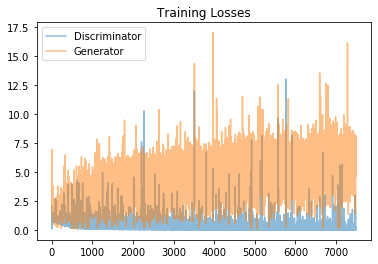

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

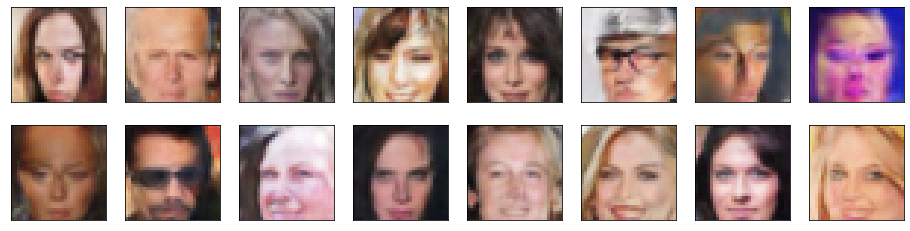

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.